# Datasets

### Cleaup & Loading

In [1]:
# Data Manipulation
import pandas as pd

# URL Library
import urllib.request
import zipfile

In [2]:
# Retrieving & storage
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [3]:
# Function Extration
def extract_zip(src, dst, member_name):
    """Extract a member file from a zip file & read it into pandas
    DataFrame.
    
    Parameters:
        src '(str:)' URL of the zip file to be downloaded and extrated.
        dst 'str': Local file path where the zip file will be written.
        member_name: Name of the member file inside the zip file to be
            read into a DataFrame.
            
    Returns:
        pandas.DataFrame containing the contents of member file.
    """
    url = src
    fname = dst
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(dst, mode='wb') as fout:
        fout.write(data)
    with zipfile.ZipFile(dst) as z:
        kag = pd.read_csv(z.open(member_name))
        kag_questions = kag.iloc[0]
        raw = kag.iloc[1:]
        return raw

In [4]:
raw = extract_zip(url, fname, member_name)

/var/folders/wh/l_q69dcj75z0c82jy8ry71f40000gn/T/ipykernel_5219/3680407660.py:22: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  kag = pd.read_csv(z.open(member_name))


## CleanUp Pipeline 

In [5]:
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.

    This function takes a Pandas DataFrame containing Kaggle 
    survey data as input and returns a new DataFrame. The 
    modifications include extracting and transforming certain 
    columns, renaming columns, and selecting a subset of columns.

    Parameters
    ----------
    df_ : pd.DataFrame
        The input DataFrame containing Kaggle survey data.

    Returns
    -------
    pd.DataFrame
        The new DataFrame with the modified and selected columns.
    """    
    return (df_
            .assign(age=df_.Q2.str.slice(0,2).astype(int),
                    education=df_.Q4.replace({'Master’s degree': 18,
                         'Bachelor’s degree': 16,
                         'Doctoral degree': 20,
'Some college/university study without earning a bachelor’s degree': 13,
                         'Professional degree': 19,
                         'I prefer not to answer': None,
                         'No formal education past high school': 12}),
                    major=(df_.Q5
                              .pipe(topn, n=3)
                              .replace({
                        'Computer science (software engineering, etc.)': 'cs',
                        'Engineering (non-computer focused)': 'eng',
                        'Mathematics or statistics': 'stat'})
                         ),
                    years_exp=(df_.Q8.str.replace('+','', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .astype(float)),
                    compensation=(df_.Q9.str.replace('+','', regex=False)
                           .str.replace(',','', regex=False)
                           .str.replace('500000', '500', regex=False)
  .str.replace('I do not wish to disclose my approximate yearly compensation',
             '0', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .fillna(0)
                           .astype(int)
                           .mul(1_000)
                                    ),
                    python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
                    r=df_.Q16_Part_2.fillna(0).replace('R', 1),
                    sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
               )#assign
        .rename(columns=lambda col:col.replace(' ', '_'))
        .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,'
                'python,r,sql'.split(',')]   
       )


In [6]:
def topn(ser, n=5, default='other'):
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

In [7]:
from feature_engine import encoding, imputation
from sklearn import base, pipeline

/Users/isisromero/opt/anaconda3/envs/Data-science-from-scratch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
class TweakKagTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, ycol=None):
        self.ycol = ycol
        
    def transform(self, X):
        return tweak_kag(X)
    
    def fit(self, X, y=None):
        return self

In [9]:
def get_rawX_y(df, y_col):
    raw = (df
           .query('Q3.isin(["United States of America", "China", "India"]) '
              'and Q6.isin(["Data Scientist", "Software Engineer"])')
    )
    return raw.drop(columns=[y_col]), raw[y_col]

In [10]:
# Create Pipeline
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
     ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True, variables=['Q1', 'Q3', 'major'])),
     ('num_impute', imputation.MeanMedianImputer(imputation_method='median', variables=['education', 'years_exp']))]
)

In [11]:
from sklearn import model_selection

In [12]:
kag_X, kag_y = get_rawX_y(raw, 'Q6')

kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
    kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [13]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)

X_test = kag_pl.transform(kag_X_test)

In [14]:
print(X_train)

       age  education  years_exp  compensation  python  r  sql  Q1_Male  \
587     25       18.0        4.0             0       1  0    1        1   
3065    22       16.0        1.0         10000       1  0    0        1   
8435    22       18.0        1.0             0       1  0    0        1   
3110    40       20.0        3.0        125000       1  0    1        0   
16372   45       12.0        5.0        100000       1  0    1        1   
...    ...        ...        ...           ...     ... ..  ...      ...   
16608   25       16.0        2.0         10000       0  0    1        1   
7325    18       16.0        1.0         30000       1  0    1        1   
21810   18       16.0        2.0             0       0  0    0        1   
4917    25       18.0        1.0        100000       1  0    1        1   
639     25       18.0        1.0         10000       1  0    0        0   

       Q1_Female  Q1_Prefer not to say  Q1_Prefer to self-describe  \
587            0             

In [15]:
kag_y_train

587      Software Engineer
3065        Data Scientist
8435        Data Scientist
3110        Data Scientist
16372    Software Engineer
               ...        
16608    Software Engineer
7325     Software Engineer
21810       Data Scientist
4917        Data Scientist
639         Data Scientist
Name: Q6, Length: 2110, dtype: object

## Exploratory Data Analysis 

In [16]:
(X_train
 .assign(data_scientist = kag_y_train == 'Data Scientist')
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
 .set_sticky(axis='index')
)

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat,data_scientist
age,1.000000,0.345717,0.644863,0.451349,0.046651,0.127667,0.134325,0.014277,-0.033693,0.051232,0.041474,0.371123,-0.363626,-0.023384,-0.223529,0.201910,0.006262,0.073864,0.075440
education,0.345717,1.000000,0.098849,0.241393,0.060259,0.151244,0.066620,-0.079534,0.064777,0.060984,0.002701,0.272790,-0.273408,-0.006441,-0.216724,0.164771,-0.001043,0.121294,0.266717
years_exp,0.644863,0.098849,1.000000,0.255164,-0.055408,0.012090,0.050181,0.083624,-0.097564,0.034470,0.016784,0.117912,-0.136666,0.029630,-0.046551,0.018267,0.004264,0.042917,-0.145461
compensation,0.451349,0.241393,0.255164,1.000000,0.165070,0.171485,0.201336,0.000967,0.002912,-0.035554,0.049881,0.616759,-0.556154,-0.123281,-0.225934,0.241580,-0.060256,0.109100,0.174434
python,0.046651,0.060259,-0.055408,0.165070,1.000000,0.183665,0.287957,0.039944,-0.039207,-0.006729,-0.000553,0.052339,-0.043101,-0.017642,-0.095136,0.093887,0.008640,0.013474,0.121741
r,0.127667,0.151244,0.012090,0.171485,0.183665,1.000000,0.276862,-0.066982,0.068157,0.004831,-0.004454,0.178682,-0.105625,-0.133029,-0.205538,0.139994,-0.022082,0.162942,0.329124
sql,0.134325,0.066620,0.050181,0.201336,0.287957,0.276862,1.000000,-0.026692,0.032639,-0.010814,-0.018499,0.166587,-0.107382,-0.108406,-0.130081,0.109862,-0.012964,0.073906,0.117941
Q1_Male,0.014277,-0.079534,0.083624,0.000967,0.039944,-0.066982,-0.026692,1.000000,-0.957007,-0.222963,-0.094664,-0.144665,0.116961,0.052566,0.062605,-0.071139,0.028492,-0.039544,-0.091126
Q1_Female,-0.033693,0.064777,-0.097564,0.002912,-0.039207,0.068157,0.032639,-0.957007,1.000000,-0.045225,-0.019201,0.131051,-0.105490,-0.048434,-0.049753,0.064054,-0.034760,0.036779,0.086614
Q1_Prefer not to say,0.051232,0.060984,0.034470,-0.035554,-0.006729,0.004831,-0.010814,-0.222963,-0.045225,1.000000,-0.004473,0.046366,-0.038587,-0.014918,-0.045908,0.010336,0.029149,0.021052,0.018540


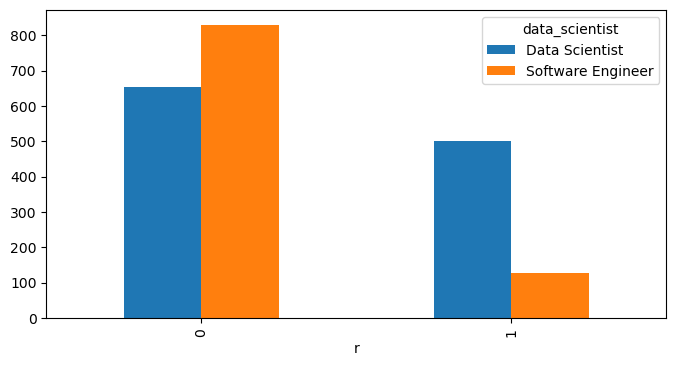

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
(X_train
 .assign(data_scientist = kag_y_train)
 .groupby('r')
 .data_scientist
 .value_counts()
 .unstack()
 .plot.bar(ax=ax)
)

plt.show()

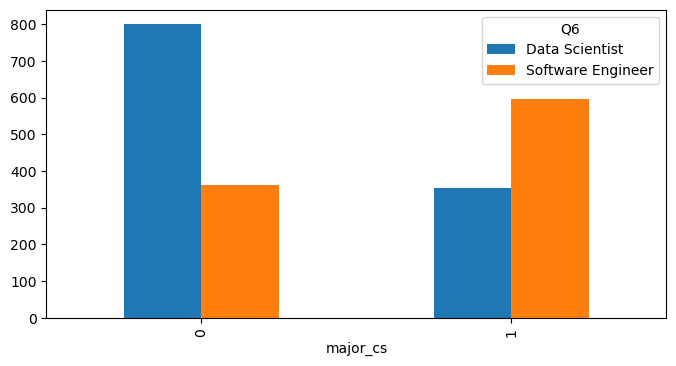

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
(pd.crosstab(index=X_train['major_cs'],
             columns=kag_y)
 .plot.bar(ax=ax)
)

plt.show()

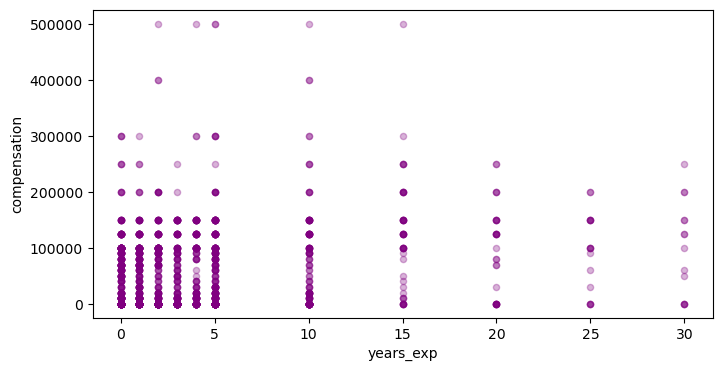

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
(X_train
 .plot.scatter(x='years_exp', y='compensation', alpha=.3, ax=ax, c='purple')
)

plt.show()

#### adding Jitter 

In [20]:
import seaborn.objects as so

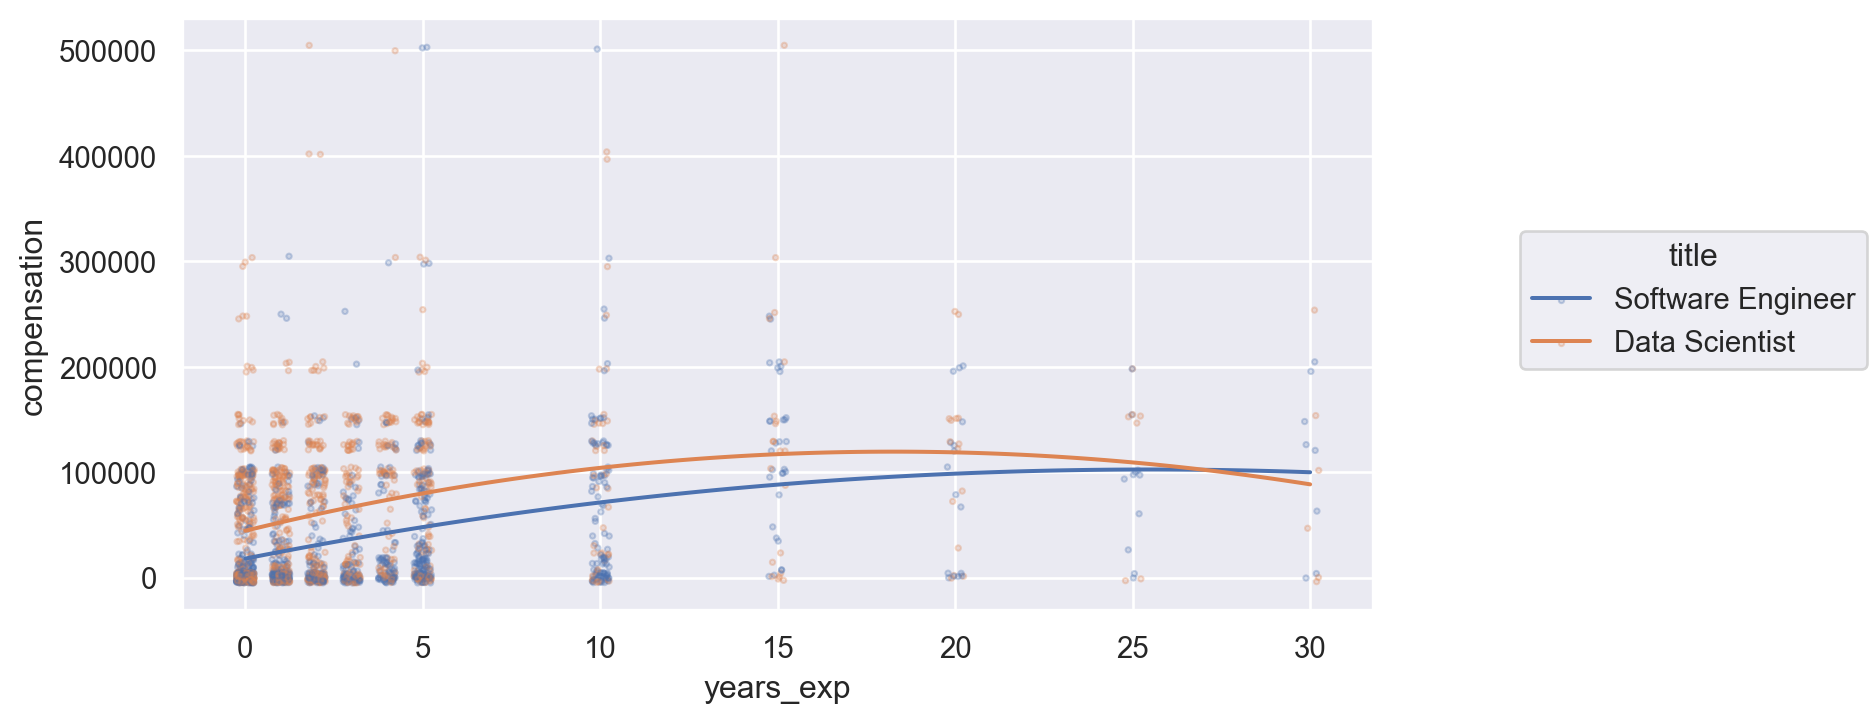

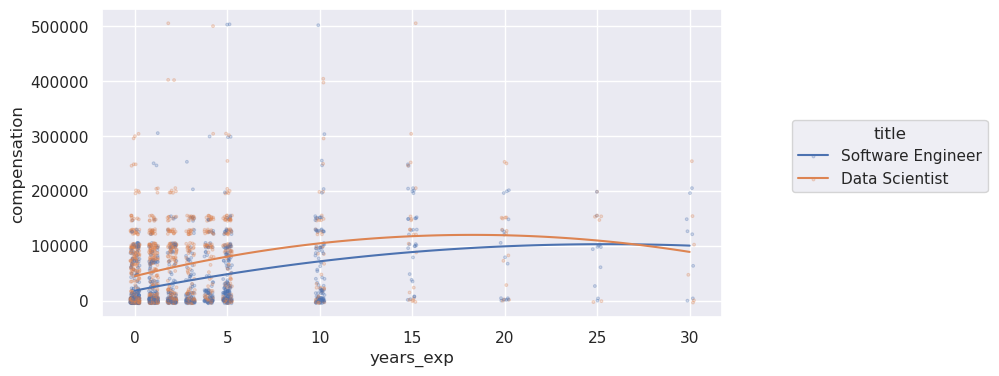

In [21]:
fig = plt.figure(figsize=(8, 4))
(so
 .Plot(X_train.assign(title=kag_y_train), x='years_exp', y='compensation', color='title')
 .add(so.Dots(alpha=.3, pointsize=2), so.Jitter(x=.5, y=10_000))
 .add(so.Line(), so.PolyFit())
 .on(fig)
 .plot()
)

#### Adjusted Visualization 

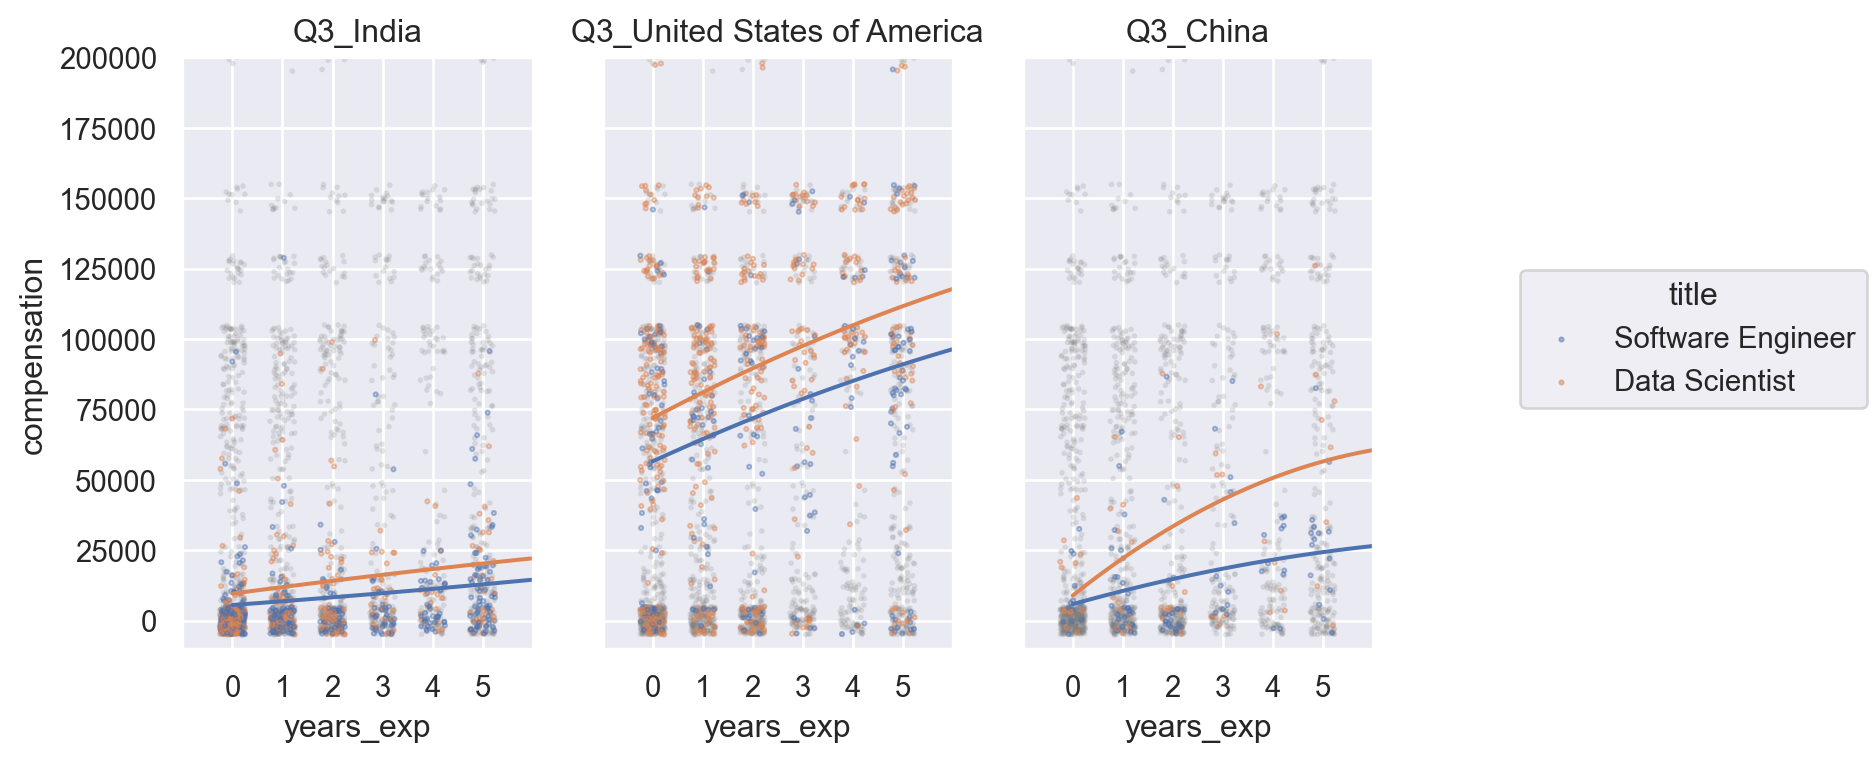

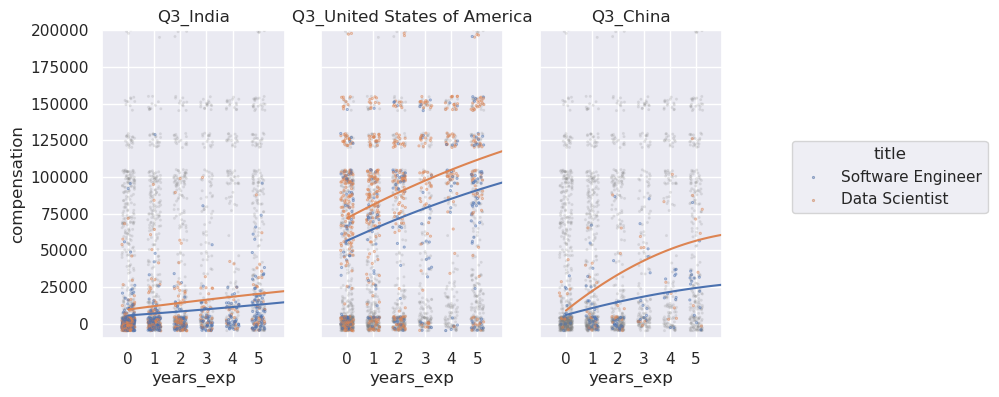

In [22]:
fig = plt.figure(figsize=(8, 4))
(so
 .Plot(X_train
       # .query('compensation < 200_000 and years_exp < 16')
       .assign(
           title=kag_y_train,
           country=(X_train
                    .loc[:, 'Q3_United States of America': 'Q3_China']
                    .idxmax(axis='columns')
                   )
       ), x='years_exp', y='compensation', color='title')
 .facet('country')
 .add(so.Dots(alpha=.01, pointsize=2, color='grey'), so.Jitter(x=.5, y=10_000), col=None)
 .add(so.Dots(alpha=.5, pointsize=1.5), so.Jitter(x=.5, y=10_000))
 .add(so.Line(pointsize=1), so.PolyFit(order=2))
 .scale(x=so.Continuous().tick(at=[0, 1, 2, 3, 4, 5]))
 .limit(y=(-10_000, 200_000), x=(-1, 6))
 .on(fig)
 .plot()
 )

## Tree Creation 

In [23]:
# Numerical Manipualtion
import numpy as np
import numpy.random as rn

In [24]:
pos_center = 12
pos_count = 100
neg_center = 7
neg_count = 1000

rs = rn.RandomState(rn.MT19937(rn.SeedSequence(42)))
gini = pd.DataFrame({'value':
                      np.append((pos_center) + rs.randn(pos_count),
                               (neg_center) + rs.randn(neg_count)),
                      'label':
                      ['pos']* pos_count + ['neg'] * neg_count})

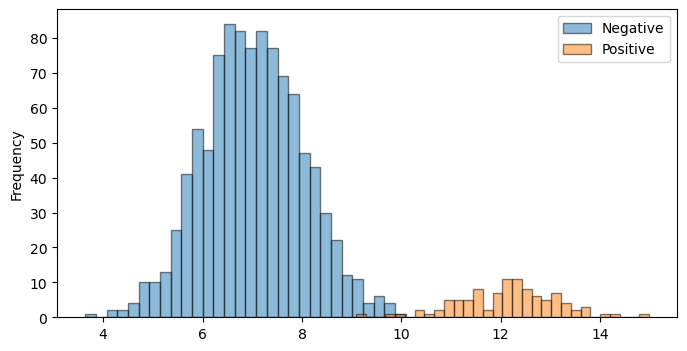

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
_ = (gini
     .groupby('label')
     [['value']]
     .plot.hist(bins=30, alpha=.5, ax=ax, edgecolor='black')
    )
ax.legend(['Negative', 'Positive'])

plt.show()

In [26]:
def calc_gini(df, val_col, label_col, pos_val, split_point,
             debug=False):
    """
    This function calculates the Gini impurity of a dataset. Gini Impurity
    is a measure of the probability of a random sample being classified
    incorectly when a feature is sued to split the data. The lower the 
    impurity, the better the split.
    
    Parameters:
    df(pd.DataFrame): The dataframe containing the data
    val_col (str): the column name of the feature used to split the data
    label_col (str): The column name of the target variable
    pos_val (str or int): The value of the target variable that represents
        the positive class
    split_point (float): The threshold used to split the data.
    debug (bool): optional, when set to True, prints the calculated Gini
        impurities and the final weighted aveerage
        
    Returns:
    float: The weighted average of Gini impurity for the positive and
        negative subsets.
    """
    ge_split = df[val_col] >= split_point
    eq_pos = df[label_col] == pos_val
    tp = df[ge_split & eq_pos].shape[0]
    fp = df[ge_split & ~eq_pos].shape[0]
    tn = df[~ge_split & ~eq_pos].shape[0]
    fn = df[~ge_split & eq_pos].shape[0]
    pos_size = tp+fp
    neg_size = tn+fn
    total_size = len(df)
    if pos_size == 0:
        gini_pos = 0
    else:
        gini_pos = 1 - (tp/pos_size)**2 - (fp/pos_size)**2
    if neg_size == 0:
        gini_neg = 0
    else:
        gini_neg = 1 - (tn/neg_size)**2 - (fn/neg_size)**2
    weighted_avg = gini_pos * (pos_size/total_size) * \
    gini_neg * (neg_size/total_size)
    if debug:
        print(f'{gini_pos=:3} {gini_neg=:.3} {weighted_avg=:3}')
    return weighted_avg

In [27]:
calc_gini(gini, val_col='value', label_col='label', pos_val='pos', split_point=9.24, debug=True)

gini_pos=0.21708826063121614 gini_neg=0.00202 weighted_avg=4.050598243782082e-05


4.050598243782082e-05

In [28]:
values = np.arange(5, 15, .1)
ginis = []
for v in values:
    ginis.append(calc_gini(gini, val_col='value', label_col='label',
                          pos_val='pos', split_point=v))

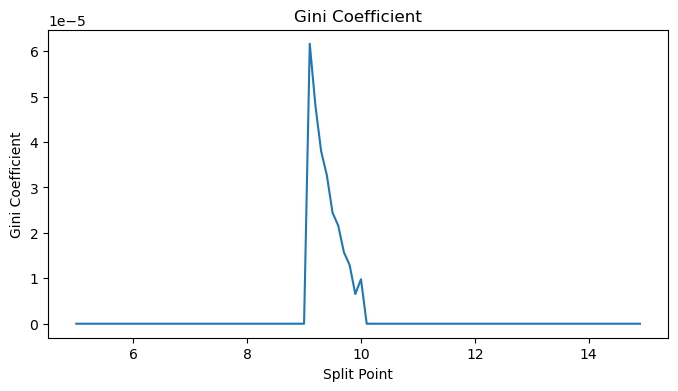

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(values, ginis)
ax.set_title('Gini Coefficient')
ax.set_ylabel('Gini Coefficient')
ax.set_xlabel('Split Point')

plt.show()

In [30]:
pd.Series(ginis, index=values).loc[9.5:10.5]

9.6     0.000022
9.7     0.000016
9.8     0.000013
9.9     0.000007
10.0    0.000010
10.1    0.000000
10.2    0.000000
10.3    0.000000
10.4    0.000000
10.5    0.000000
dtype: float64

In [31]:
print(pd.DataFrame({'gini':ginis, 'split':values})
      .query('gini <= gini.min()'))

    gini  split
0    0.0    5.0
1    0.0    5.1
2    0.0    5.2
3    0.0    5.3
4    0.0    5.4
..   ...    ...
95   0.0   14.5
96   0.0   14.6
97   0.0   14.7
98   0.0   14.8
99   0.0   14.9

[90 rows x 2 columns]


#### Coeffiecients in Trees

In [32]:
from sklearn import tree
stump = tree.DecisionTreeClassifier(max_depth=1)
stump.fit(gini[['value']], gini.label)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'value <= 9.708\ngini = 0.165\nsamples = 1100\nvalue = [1000, 100]\nclass = neg'),
 Text(0.25, 0.25, 'gini = 0.002\nsamples = 999\nvalue = [998, 1]\nclass = neg'),
 Text(0.75, 0.25, 'gini = 0.039\nsamples = 101\nvalue = [2, 99]\nclass = pos')]

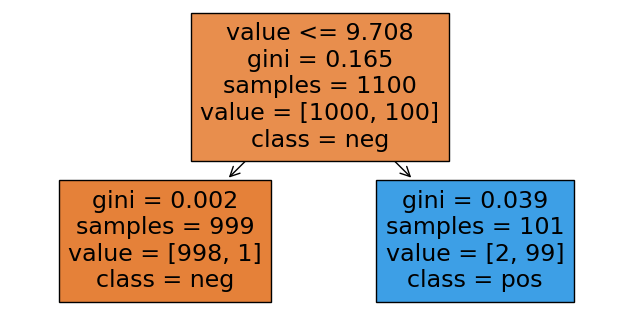

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
tree.plot_tree(stump, feature_names=['value'],
               filled=True, 
               class_names=stump.classes_,
               ax=ax)

In [34]:
gini_pos = 0.039
gini_neg = 0.002
pos_size = 101
neg_size = 999
total_size = pos_size + neg_size
weighted_avg = gini_pos * (pos_size/total_size) + \
gini_neg * (neg_size/total_size)

In [35]:
print(weighted_avg)

0.005397272727272727


In [36]:
import xgboost as xgb

In [37]:
# from graphviz import Digraph

# dot = Digraph(comment='The Round Table')
# dot.node('A', 'King Arthur')
# dot.node('B', 'Sir Bedevere the Wise')
# dot.node('L', 'Sir Lancelot the Brave')

# dot.edges(['AB', 'AL'])
# dot.edge('B', 'L', constraint='false')
# print(dot.source)

In [38]:
xg_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
xg_stump.fit(gini[['value']], (gini.label== 'pos'))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

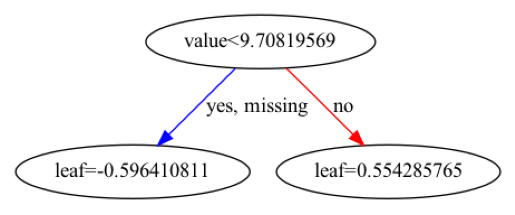

In [39]:
import os
os.environ["PATH"] += os.pathsep + '/Users/isisromero/opt/anaconda3/envs/Data-science-from-scratch/bin'


xgb.plot_tree(xg_stump, num_trees=0)

plt.show()

In [40]:
import subprocess

def my_dot_export(xg, num_trees, filename, title='', direction='TB'):
    """Exports a specified number of trees from an XGBoost model as a graph 
    visualization in dot and png formats.

    Args:
        xg: An XGBoost model.
        num_trees: The number of tree to export.
        filename: The name of the file to save the exported visualization.
        title: The title to display on the graph visualization (optional).
        direction: The direction to lay out the graph, either 'TB' (top to 
            bottom) or 'LR' (left to right) (optional).
    """
    res = xgb.to_graphviz(xg, num_trees=num_trees)
    content = f'''    node [fontname = "Helvetica"];
    edge [fontname = "Helvetica Thin"];
    label = "{title}"
    fontname = "Helvetica"
    '''
    out = res.source.replace('graph [ rankdir=TB ]', 
                             f'graph [ rankdir={direction} ];\n {content}')
    # dot -Gdpi=300 -Tpng -ocourseflow.png courseflow.dot 
    dot_filename = filename
    with open(dot_filename, 'w') as fout:
        fout.write(out)
    png_filename = dot_filename.replace('.dot', '.png')
    subprocess.run(f'dot -Gdpi=300 -Tpng -o{png_filename} {dot_filename}'.split())

In [41]:
my_dot_export(xg_stump, num_trees=0, filename='/Users/isisromero/Desktop/img_XGB/stump_xg.dot', title='A demo stump')

#### Another Visualization Tool 

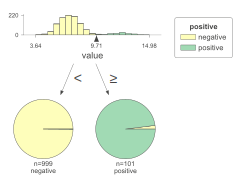

In [42]:
import dtreeviz
viz = dtreeviz.model(xg_stump, X_train=gini[['value']], 
                     y_train=gini.label=='pos',
    target_name='positive',
    feature_names=['value'], class_names=['negative', 'positive'],
    tree_index=0)
viz.view()

## Stumps on Real Data

In [43]:
stump_dt = tree.DecisionTreeClassifier(max_depth=1)
X_train = kag_pl.fit_transform(kag_X_train)
stump_dt.fit(X_train, kag_y_train)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]\nclass = Data Scientist'),
 Text(0.25, 0.25, 'gini = 0.493\nsamples = 1484\nvalue = [653, 831]\nclass = Software Engineer'),
 Text(0.75, 0.25, 'gini = 0.322\nsamples = 626\nvalue = [500, 126]\nclass = Data Scientist')]

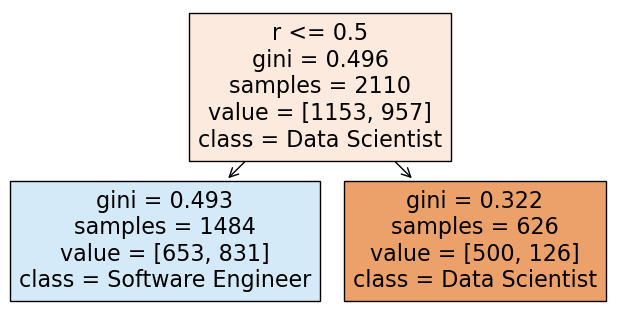

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(stump_dt, feature_names=features,
               filled=True,
               class_names=stump_dt.classes_,
               ax=ax)

In [45]:
X_test = kag_pl.transform(kag_X_test)

In [46]:
stump_dt.score(X_test, kag_y_test)

0.6243093922651933

#### The Dummy Classifier

In [47]:
from sklearn import dummy

In [48]:
dummy_model = dummy.DummyClassifier()

In [49]:
dummy_model.fit(X_train, kag_y_train)

DummyClassifier()

In [50]:
dummy_model.score(X_test, kag_y_test)

0.5458563535911602

In [51]:
import xgboost as xgb

In [52]:
kag_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
kag_stump.fit(X_train, kag_y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['Data Scientist' 'Software Engineer']

In [53]:
print(kag_y_train)

587      Software Engineer
3065        Data Scientist
8435        Data Scientist
3110        Data Scientist
16372    Software Engineer
               ...        
16608    Software Engineer
7325     Software Engineer
21810       Data Scientist
4917        Data Scientist
639         Data Scientist
Name: Q6, Length: 2110, dtype: object


In [54]:
print(kag_y_train == 'Software Engineer')

587       True
3065     False
8435     False
3110     False
16372     True
         ...  
16608     True
7325      True
21810    False
4917     False
639      False
Name: Q6, Length: 2110, dtype: bool


#### Using Label Encoder

In [55]:
from sklearn import preprocessing

In [56]:
label_encoder = preprocessing.LabelEncoder()

In [57]:
y_train = label_encoder.fit_transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

In [58]:
y_test[:5]

array([1, 0, 0, 1, 1])

In [59]:
label_encoder.classes_

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [60]:
# Inverse Tranformation Procedure
label_encoder.inverse_transform([0, 1])

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [61]:
kag_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
kag_stump.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [62]:
kag_stump.score(X_test, y_test)

0.6243093922651933

In [63]:
my_dot_export(kag_stump, num_trees=0, filename='/Users/isisromero/Desktop/img_XGB/stump_xg.dot',
             title='XGBoost Stump')

In [64]:
kag_stump.classes_

array([0, 1])

In [65]:
def inv_logit(p: float) -> float:
    """
    Compute the inverse logit function of a given value.

    The inverse logit function is defined as:
        f(p) = exp(p) / (1 + exp(p))

    Parameters
    ----------
    p : float
        The input value to the inverse logit function.

    Returns
    -------
    float
        The output of the inverse logit function.
    """
    return np.exp(p) / (1 + np.exp(p))

In [66]:
inv_logit(.07117741922)

0.5177868460919524

In [67]:
inv_logit(-.3592)

0.41115323716754393

Text(-3, 0.4, 'Predict Negative')

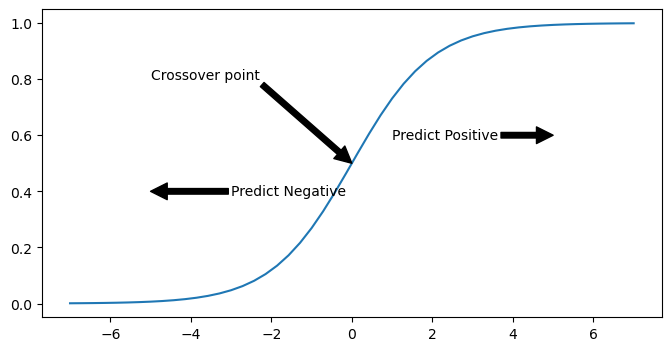

In [68]:
fig, ax = plt.subplots(figsize=(8, 4))
vals = np.linspace(-7, 7)
ax.plot(vals, inv_logit(vals))
ax.annotate('Crossover point', (0,.5), (-5,.8), arrowprops={'color':'k'})
ax.annotate('Predict Positive', (5,.6), (1,.6), va='center', arrowprops={'color':'k'})
ax.annotate('Predict Negative', (-5,.4), (-3,.4), va='center', arrowprops={'color':'k'})

## Model Complexity & Hyperparameters

#### Underfit Model

In [69]:
underfit = tree.DecisionTreeClassifier(max_depth=1)
X_train = kag_pl.fit_transform(kag_X_train)

In [70]:
underfit.fit(X_train, kag_y_train)

DecisionTreeClassifier(max_depth=1)

In [71]:
underfit.score(X_test, kag_y_test)

0.6243093922651933

#### Overfitting with Decision Trees 

In [72]:
hi_variance = tree.DecisionTreeClassifier(max_depth=None)
X_train = kag_pl.fit_transform(kag_X_train)

In [73]:
hi_variance.fit(X_train, kag_y_train)

DecisionTreeClassifier()

In [74]:
hi_variance.score(X_test, kag_y_test)

0.6596685082872928

[Text(0.6582503916378565, 0.9772727272727273, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]'),
 Text(0.3974685339239412, 0.9318181818181818, 'major_cs <= 0.5\ngini = 0.493\nsamples = 1484\nvalue = [653, 831]'),
 Text(0.1936531033923941, 0.8863636363636364, 'Q3_United States of America <= 0.5\ngini = 0.49\nsamples = 718\nvalue = [410, 308]'),
 Text(0.07922226123595505, 0.8409090909090909, 'years_exp <= 0.5\ngini = 0.491\nsamples = 322\nvalue = [140, 182]'),
 Text(0.026361279170267933, 0.7954545454545454, 'education <= 17.0\ngini = 0.463\nsamples = 74\nvalue = [47, 27]'),
 Text(0.019878997407087293, 0.75, 'age <= 27.5\ngini = 0.499\nsamples = 40\nvalue = [21, 19]'),
 Text(0.018150388936905792, 0.7045454545454546, 'major_stat <= 0.5\ngini = 0.5\nsamples = 38\nvalue = [19, 19]'),
 Text(0.016421780466724288, 0.6590909090909091, 'compensation <= 55000.0\ngini = 0.498\nsamples = 36\nvalue = [17, 19]'),
 Text(0.014693171996542784, 0.6136363636363636, 'compensation <= 15000.0\ngi

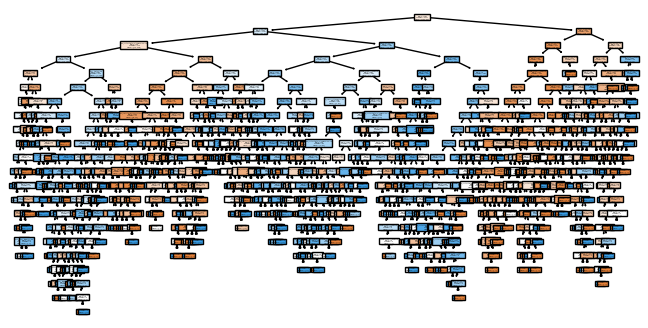

In [75]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(hi_variance, feature_names=features, filled=True)

[Text(0.5, 0.875, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]\nclass = Data Scientist'),
 Text(0.25, 0.625, 'major_cs <= 0.5\ngini = 0.493\nsamples = 1484\nvalue = [653, 831]\nclass = Software Engineer'),
 Text(0.125, 0.375, 'Q3_United States of America <= 0.5\ngini = 0.49\nsamples = 718\nvalue = [410, 308]\nclass = Data Scientist'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'years_exp <= 2.5\ngini = 0.433\nsamples = 766\nvalue = [243, 523]\nclass = Software Engineer'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'major_cs <= 0.5\ngini = 0.322\nsamples = 626\nvalue = [500, 126]\nclass = Data Scientist'),
 Text(0.625, 0.375, 'years_exp <= 22.5\ngini = 0.211\nsamples = 443\nvalue = [390, 53]\nclass = Data Scientist'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'years_exp <= 7.5\ngini = 0.48\nsamples = 183\nval

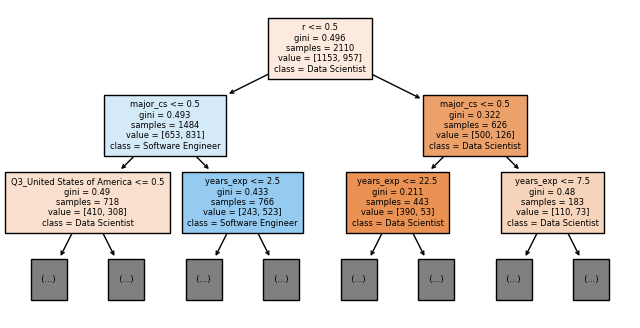

In [76]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(hi_variance, feature_names=features, filled=True, class_names=hi_variance.classes_,
              max_depth=2, fontsize=6)

## Tree Hyperparameters 